In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# path de tu csv
path = "D:/UsX/Escritorio/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.csv"
df = pd.read_csv(path)
df.rename(columns={'time_abs(%Y-%m-%dT%H:%M:%S.%f)': 'date', 'time_rel(sec)': 'time', 'velocity(m/s)': 'velocity'}, inplace=True)
df.columns


FileNotFoundError: [Errno 2] No such file or directory: ''

In [7]:
df.interpolate(method='linear', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['velocity']] = scaler.fit_transform(df[['velocity']])

C:\Users\UsX\AppData\Local\Temp\ipykernel_22772\2211336646.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [8]:
def extract_features(df, window_size=100):
    windows = []
    for start in range(0, len(df), window_size):
        window = df['velocity'][start:start+window_size]
        if len(window) == window_size:
            windows.append([
                np.mean(window),
                np.std(window),
                np.max(window),
                np.min(window),
                np.median(window)
            ])
    return np.array(windows)

# Extract features
features = extract_features(df)

In [9]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(features)

# Predict anomalies (1 = normal, -1 = anomaly)
anomalies = iso_forest.predict(features)

# Identify anomaly indices
anomaly_indices = np.where(anomalies == -1)[0]


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build an autoencoder model
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(features.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(features.shape[1], activation='sigmoid')
])

# Compile and train the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(features, features, epochs=50, batch_size=32, shuffle=True)

# Reconstruction error
reconstructions = autoencoder.predict(features)
mse = np.mean(np.power(features - reconstructions, 2), axis=1)

# Thresholding the error to identify anomalies
threshold = np.percentile(mse, 95)  # Set threshold as the 95th percentile
anomalies = mse > threshold
anomaly_indices = np.where(anomalies)[0]


Epoch 1/50


c:\Users\UsX\miniconda3\envs\nsa\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0292
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1802e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 3.2356e-04
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 9.0468e-05
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5039e-05 
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1213e-05
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3235e-05
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 3.3000e-05
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 3.3497e-05
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 2.8675e-05
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8043e-05  
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 3.0795e-05
Epoch 13/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 2.9033e-05
Epoch 14/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 2.9579e-

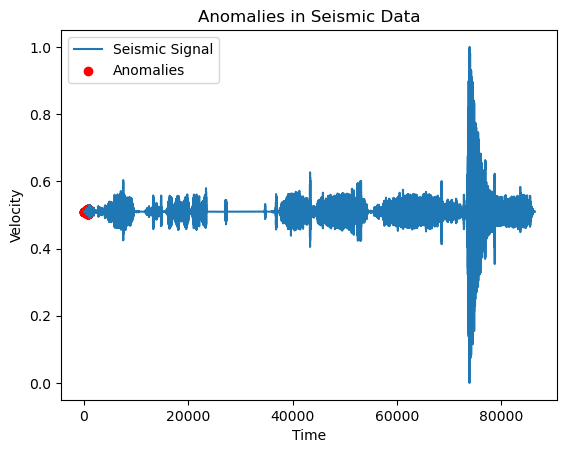

In [12]:
import matplotlib.pyplot as plt

# Plot time series with anomalies
plt.plot(df['time'], df['velocity'], label='Seismic Signal')
plt.scatter(df['time'][anomaly_indices], df['velocity'][anomaly_indices], color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Anomalies in Seismic Data')
plt.legend()
plt.show()